### Tutorial — BayesBay Workbook: Rayleigh Wave Dispersion

This notebook generates synthetic Rayleigh wave dispersion data (using **disba**) and performs a transdimensional (TD) Bayesian inversion (using **BayesBay**) to solve for a 1-D shear-wave velocity profile.

To keep the workflow simple and focused on learning the core concepts of TD Bayes with BayesBay, supplemental functions are stored in external `.py` files:

- **`smo_plotting_swd.py`** — Plotting functions for models, data, and solutions (some call BayesBay utilities).
- **`smo_models.py`** — Example Earth models and code to format them for **disba**.

The notebook follows a more linear, step-by-step structure than the standard BayesBay tutorials, with all key user-defined variables grouped in one cell, followed by sequential implementation steps:

1. **Import packages**  
2. **Create synthetic data** (and optionally explore sensitivities)  
3. **Set user-defined variables** and prepare frameworks for TD Bayes implementation  
4. **Run inversion**  
5. **Plot results**

In [3]:
###################
# IMPORT PACKAGES #
###################

import bayesbay as bb
from bayesbay.discretization import Voronoi1D
from bayesbay.likelihood import Target
from bayesbay.likelihood import LogLikelihood

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

import importlib
import smo_plotting_swd as sf
import smo_models as models

from disba import PhaseDispersion
np.random.seed(30)

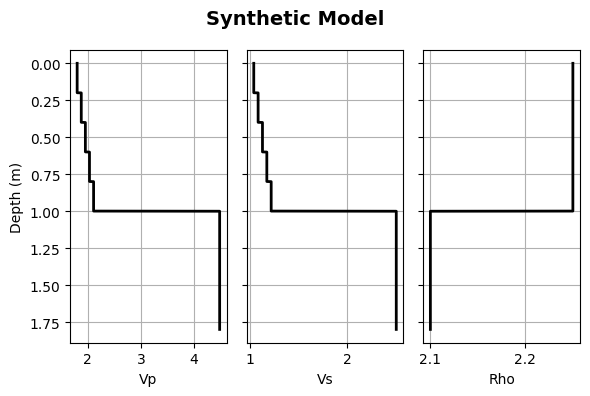

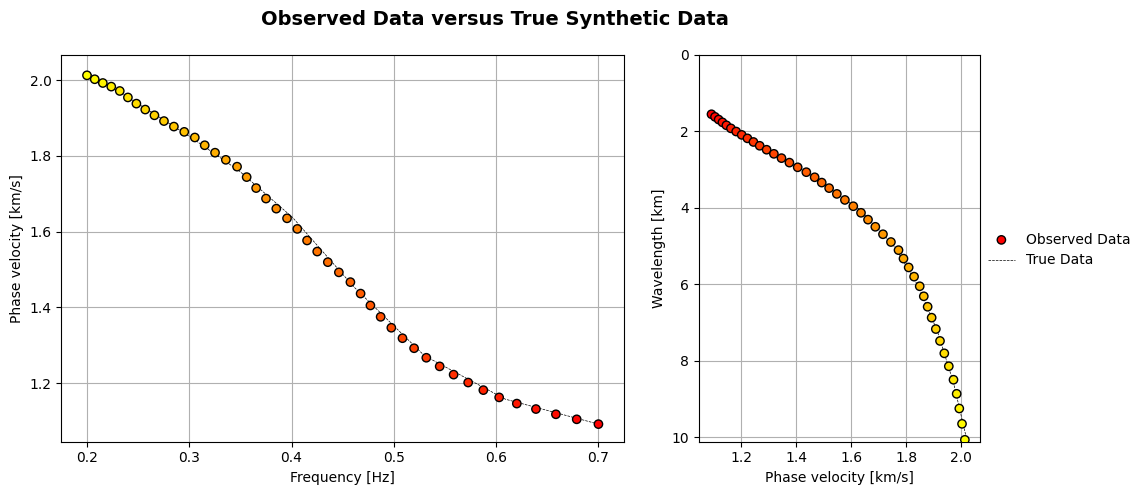

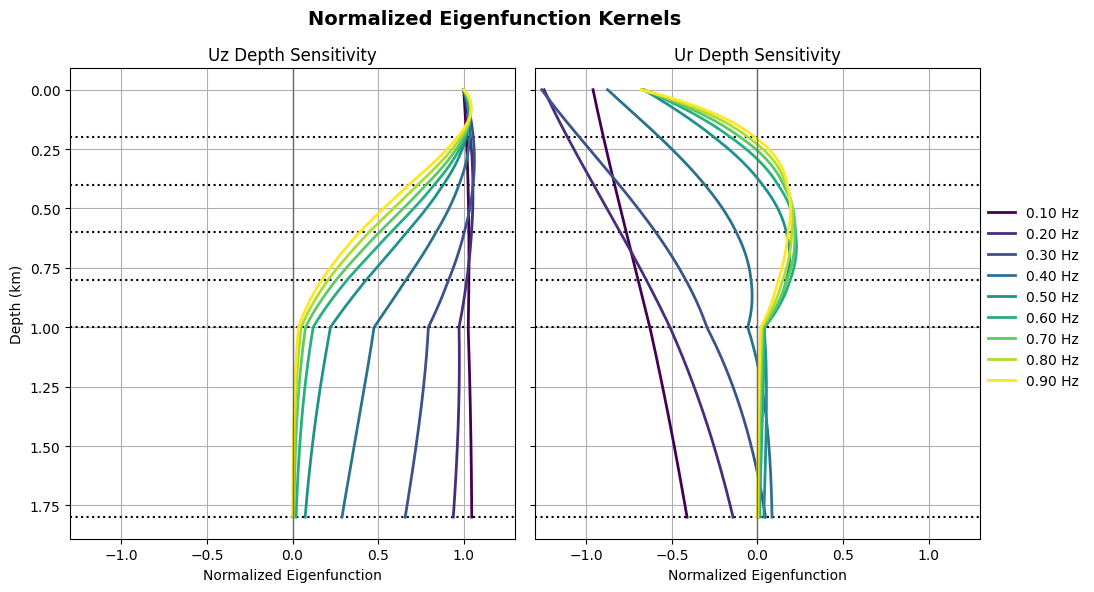

In [6]:
importlib.reload(models)
importlib.reload(sf)

##########################
# CREATE SYNTHETIC MODEL #
##########################
thick, vp, vs, rho = models.gom_nowater()
THICK, VP, VS, RHO = models.generate(thick, vp, vs, rho)

# Velocity model in format of: thickness, Vp, Vs, density (km, km/s, km/s, g/cm3)
velocity_model = np.column_stack((THICK/1000, VP/1000, VS/1000, RHO/1000))[::-1]
depths = np.cumsum(velocity_model[:,0])

fig, ax = sf.plot_synthetic_model(velocity_model, depths)

########################
# CREATE OBSERVED DATA #
########################

# Periods must be sorted starting with low periods
minfreq = .2
maxfreq = .7
periods = np.geomspace(1/maxfreq, 1/minfreq, 10)   

pd = PhaseDispersion(*velocity_model.T)
f_true = 1/periods
d_true = pd(periods, mode=0, wave="rayleigh").velocity

# add some noise to the true SWD data
noise_std_true = 0.005
d_obs0 = d_true + np.random.normal(0, noise_std_true, d_true.size)

wl_obs0 =  d_obs0 / f_true

# Resample the composite dispersion curve and its upper/lower boundary curves
# at no_points logarithmically or linearly spaced points
no_points = 45
wl_obs = np.logspace(np.log10(min(wl_obs0)), np.log10(max(wl_obs0)), num=no_points)

interp_func = interp1d(wl_obs0,d_obs0,kind='linear', fill_value='extrapolate')
d_obs = interp_func(wl_obs)

f_obs = d_obs/wl_obs


# Truncate samples if desired
d_obs = d_obs[:]
f_obs = f_obs[:]

fig, ax = sf.plot_observed_data(f_obs, d_obs, f_true, d_true)


################################
# EXPLORING DATA SENSITIVITIES #
################################
from disba import EigenFunction
eigf = EigenFunction(*velocity_model.T)

#fig, ax = sf.plot_rayleigh_eigenfunctions(velocity_model, thick, np.unique(f_obs.astype(int)))
fig, ax = sf.plot_rayleigh_eigenfunctions(velocity_model, thick, np.arange(.1,1,.1))

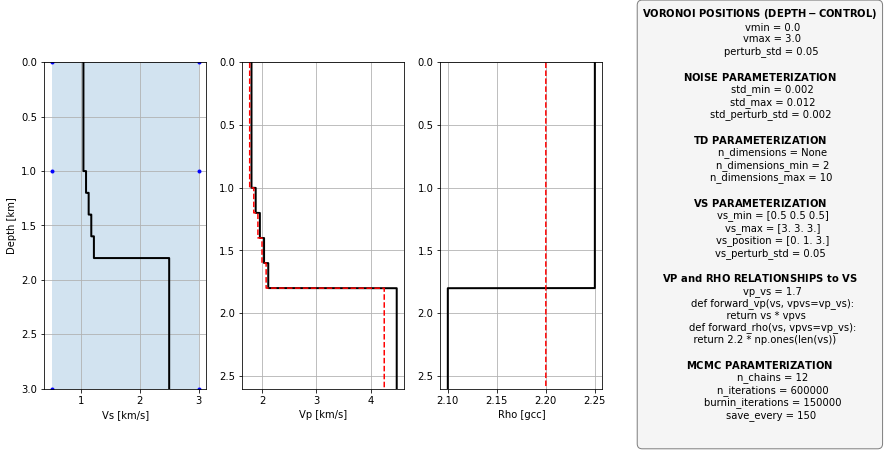

In [3]:
importlib.reload(sf)

### 01 VORONOI POSITIONS (km)
vmin=0.0
vmax=3.0
perturb_std=.05

### 02 VELOCITY MODEL SPACE
# Define upper and lower bounds i.e. vmax and vmin
vs_min=np.array([.8, 1.0, 1.2])
vs_max=np.array([2.0, 3.0, 3.0])
vs_min=np.array([.5, .5, .5])
vs_max=np.array([3.0, 3.0, 3.0])
# Define control points (position in discretization domain) for defining a depth-dependent Vs prior
vs_position=np.array([0, 1, vmax])
# Define standard deviation of the Gaussians used to randomly perturb the parameter i.e. perturb_std (km/s)
vs_perturb_std=0.05

### 03 TD PARAMETERS
n_dimensions=None
n_dimensions_min=2  # ignored if n_dimensions is defined 
n_dimensions_max=10 # ignored if n_dimensions is defined

### 04 NOISE
std_min=0.002
std_max=0.012
std_perturb_std=0.002

### 05 FORWARD MODELER
vp_vs = 1.7
def forward_vp(vs, vpvs=vp_vs):
    return vs * vpvs
def forward_rho(vs, vpvs=vp_vs):
    return 2.2 * np.ones(len(vs))

def forward_sw(state):
    voronoi = state["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    
    vp = forward_vp(vs)
    rho = forward_rho(vs)
    pd = PhaseDispersion(thickness, vp, vs, rho)
    d_pred = pd(1/f_obs, mode=0, wave="rayleigh").velocity
    return d_pred

### 06 MCMC PARAMETERS
n_chains=12
n_iterations=600_000
burnin_iterations=150_000
save_every=150


####################################################################################################
# DEFINE INITIAL MODEL and PRIORS for VS and DEPTH #
####################################################################################################
def initialize_vs(param, positions=vs_position):
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    return sorted_vals

# A uniform Vs prior
vs = bb.prior.UniformPrior(name="vs", vmin=vs_min, vmax=vs_max, position=vs_position, perturb_std=vs_perturb_std)
start = initialize_vs
vs.set_custom_initialize(initialize_vs)

# Plot prior
depth_prior = np.linspace(0, max(vs_position))  
vmin_prior, vmax_prior = vs.get_vmin_vmax(depth_prior) # get bounds for every depth in depth prior

fig, ax = sf.plot_parameters(forward_vp, forward_rho,
    vmin, vmax, perturb_std, std_min, std_max, std_perturb_std,
    n_dimensions, n_dimensions_min, n_dimensions_max,
    vs_min, vs_max, vs_position, vs_perturb_std, vp_vs,
    n_chains, n_iterations, burnin_iterations, save_every,
    vmin_prior, vmax_prior, depth_prior, Voronoi1D, velocity_model, depths)

ax[0].set_ylim(vmax,0)

####################################################################################################
# BUILD DISCRETIZED SPACE 
# i.e. parameters for each nuclei, and rules for how it can be manipulated #
####################################################################################################
voronoi = Voronoi1D(name="voronoi", vmin=vmin,vmax=vmax, perturb_std=perturb_std,      
    n_dimensions=n_dimensions, n_dimensions_min=n_dimensions_min, n_dimensions_max=n_dimensions_max,
    parameters=[vs], birth_from='neighbour')
    # can initialize the free parameters associated with the newborn Voronoi cell by 
    # randomly drawing from their prior or by perturbing the value found in the nearest Voronoi cell (default).
parameterization = bb.parameterization.Parameterization(voronoi)


####################################################################################################
# BUILD FRAMEWORK for LOGLIKELIHOOD 
# i.e. the forward modeling of calculated data and how it is compared to observed TARGET data #
####################################################################################################
target = Target("rayleigh", d_obs, std_min=std_min, std_max=std_max, std_perturb_std=std_perturb_std)
log_likelihood = LogLikelihood(targets=target, fwd_functions=forward_sw)

In [4]:
##################################################################################################
# INVERSION SET UP AND RAN based on FREE PARAMETERS, LOGLIKELIHOOD FRAMEWORK and MCMC PARAMETERS #
##################################################################################################

inversion = bb.BayesianInversion(parameterization=parameterization, log_likelihood=log_likelihood,n_chains=n_chains)
inversion.run(sampler=None, n_iterations=n_iterations, burnin_iterations=burnin_iterations, save_every=save_every, verbose=False)

for chain in inversion.chains:
    chain.print_statistics()

Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 600000
ACCEPTANCE RATE: 88187/600000 (14.70 %)
PARTIAL ACCEPTANCE RATES:
	NoisePerturbation(rayleigh): 27035/85943 (31.46%)
	ParamSpacePerturbation(param_space_name=voronoi):
		BirthPerturbation(voronoi): 649.00/85522.00 (0.76%)
		DeathPerturbation(voronoi): 647.00/85772.00 (0.75%)
		ParamPerturbation(voronoi.discretization): 17094.00/85770.00 (19.93%)
		ParamPerturbation(voronoi.vs): 42762.00/256993.00 (16.64%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 600000
ACCEPTANCE RATE: 104288/600000 (17.38 %)
PARTIAL ACCEPTANCE RATES:
	NoisePerturbation(rayleigh): 28184/86162 (32.71%)
	ParamSpacePerturbation(param_space_name=voronoi):
		BirthPerturbation(voronoi): 553.00/85441.00 (0.65%)
		DeathPerturbation(voronoi): 549.00/85836.00 (0.64%)
		ParamPerturbation(voronoi.discretization): 15379.00/85419.00 (18.00%)
		ParamPerturbation(voronoi.vs): 59623.00/257142.00 (23.19%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 600000
ACCEPTANCE RATE: 54894/60000

(0.0, 1.0)

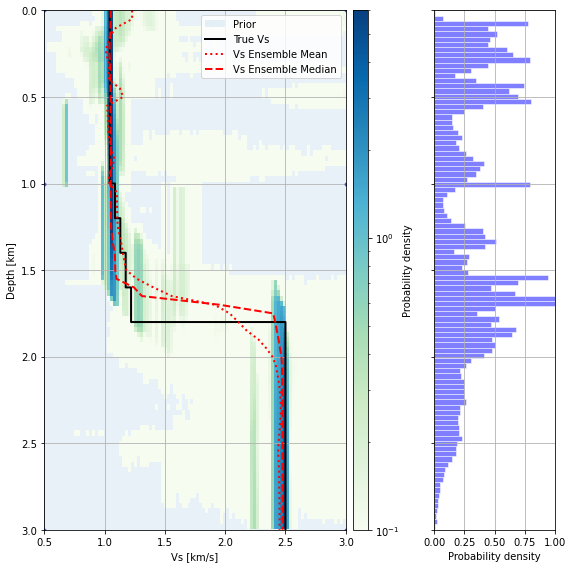

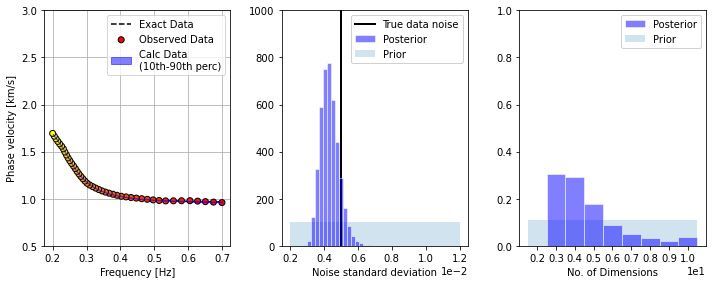

In [5]:
importlib.reload(sf)

results = inversion.get_results(concatenate_chains=True)

#######################################
# GET RESULTS related to VS and DEPTH #
#######################################
sampled_voronoi_nuclei = results['voronoi.discretization']
sampled_thickness = [Voronoi1D.compute_cell_extents(n) for n in sampled_voronoi_nuclei]
sampled_vs = results['voronoi.vs']

step=.05 # increment by 50m
N = int(vmax / step) + 1
interp_depths = np.linspace(0, vmax, N)

statistics_vs = Voronoi1D.get_tessellation_statistics(sampled_thickness, sampled_vs, interp_depths, input_type='extents')

interf_bins=100
fig, ax = sf.plot_vs_depth_posteriors(depth_prior, vmin_prior, vmax_prior, vs_min, vs_max, vs_position, 
                                      sampled_thickness, sampled_vs, statistics_vs, 
                                      interp_depths, sampled_voronoi_nuclei, Voronoi1D, interf_bins, velocity_model);

ax[0].set_ylim(3,0)
ax[1].set_ylim(*ax[0].get_ylim())

ax[1].set_xlim(0,1)

ax[0].grid()
ax[1].grid()


################################
# GET RESULTS related to NOISE #
################################
d_pred = np.array(results['rayleigh.dpred'])
percentiles = np.percentile(d_pred, (10, 90), axis=0)

noise_bins=20
fig, ax = sf.plot_data_noise_posterior(f_obs, d_obs, n_dimensions_min, n_dimensions_max, percentiles, results, target, noise_bins, noise_std_true, f_true, d_true)
ax[0].set_ylim(.5,3)
ax[1].set_ylim(0,1e3)
ax[2].set_ylim(0,1)


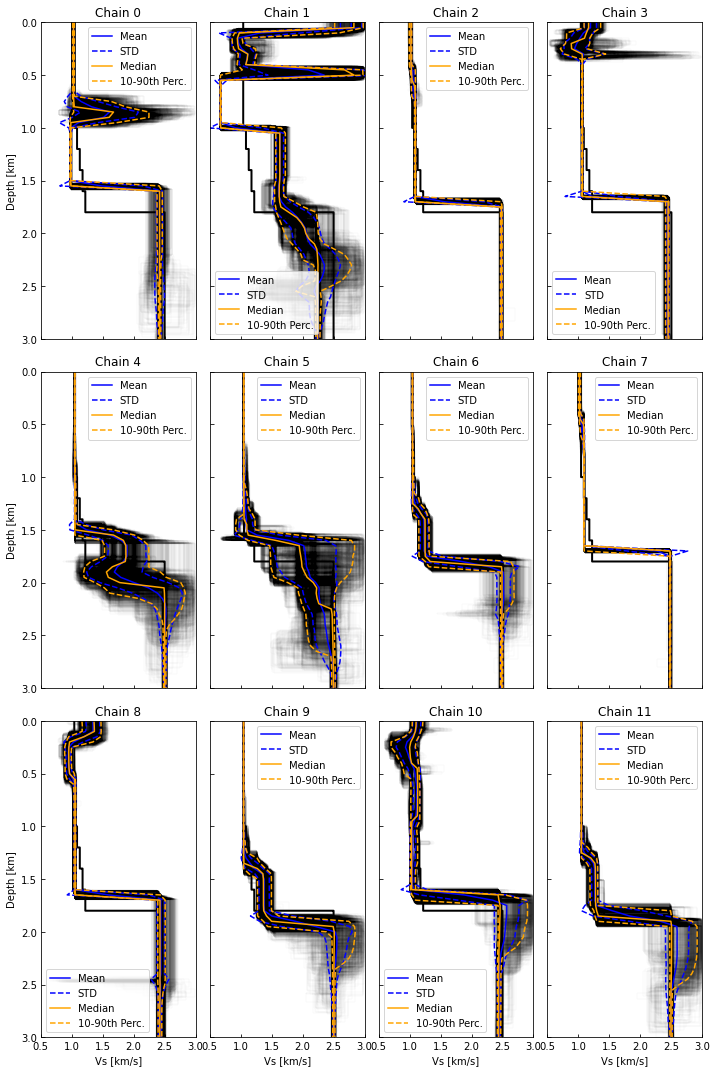

(3.0, 0.0)

In [6]:
importlib.reload(sf)
fig, ax = sf.plot_chains(inversion, Voronoi1D, interp_depths, vmin, vmax, np.min(vs_min), np.max(vs_max), velocity_model);
ax[0][0].set_ylim(3,0)